In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# Read data
data = pd.read_csv("global_air_pollution_with_outliers.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             23036 non-null  object 
 1   City                23462 non-null  object 
 2   AQI Value           23463 non-null  int64  
 3   AQI Category        23463 non-null  object 
 4   CO AQI Value        23463 non-null  int64  
 5   CO AQI Category     23463 non-null  object 
 6   Ozone AQI Value     23463 non-null  int64  
 7   Ozone AQI Category  23463 non-null  object 
 8   NO2 AQI Value       23463 non-null  float64
 9   NO2 AQI Category    23463 non-null  object 
 10  PM2.5 AQI Value     23463 non-null  float64
 11  PM2.5 AQI Category  23463 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 2.1+ MB
None


In [5]:
# Drop unnecessary columns
from sklearn.model_selection import train_test_split
drop_column = ["Country", "City", "AQI Value"] # Column of AQI Value is dropped cause we want to predict AQI Category from AQI value and category of pollutants
x = data.drop(drop_column, axis=1) # Features
y = data["AQI Category"] # Targer variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder
# Encode the target variable to numeric values
# This allows compatibility with machine learning models
# Encode the target variable
category_value = ["Good", "Moderate", "Unhealthy", "Unhealthy for Sensitive Groups", "Very Unhealthy", "Hazardous"]
encoder = LabelEncoder()
y = encoder.fit_transform(y)  # Converts AQI categories to numeric labels


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
# Define preprocessing for numerical and ordinal (categorical) features
# Numerical features: Impute missing values and scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with the median
    ('scaler', StandardScaler())  # Normalize the data
])

# Ordinal features: Impute missing values and encode AQI categories
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing values with the most frequent value
    ('encoder', OrdinalEncoder(categories=[category_value]*4))  # Encode categories into ordinal numbers
])

# Combine preprocessing steps for different feature types
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["CO AQI Value", "Ozone AQI Value", "NO2 AQI Value", "PM2.5 AQI Value"]),
    ("ord_features", ord_transformer, ["CO AQI Category", "Ozone AQI Category", "NO2 AQI Category", "PM2.5 AQI Category"])
])

# Apply preprocessing to the training and testing data
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [9]:
# Encode the target variable for the model
target_encoder = OrdinalEncoder(categories=[category_value])
y_train_encoded = target_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_encoded = target_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

In [10]:
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# Define a custom scorer to focus on the F1-score for the 'Hazardous' category
# This helps in prioritizing the model's performance for the minority class
f1_hazardous_scorer = make_scorer(f1_score, labels=[5], average=None)

# Initialize the XGBClassifier model
model = XGBClassifier(eval_metric="mlogloss", random_state=42, gamma=0)

# Define a parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    "learning_rate": [0.05, 0.01],  # Learning rate controls the step size at each iteration
    "n_estimators": [20, 50, 100],  # Number of trees in the model
    "max_depth": [7, 9],  # Maximum depth of the trees
    "subsample": [0.6, 0.8],  # Fraction of samples to use for training each tree
    "colsample_bytree": [0.6, 0.8]  # Fraction of features to use for training each tree
}

# Perform GridSearchCV to find the best hyperparameters
# The evaluation metric focuses on the F1-score for the 'Hazardous' class
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring=f1_hazardous_scorer, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train_encoded)

# Get the best model and parameters from GridSearchCV
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score for 'Hazardous':", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}
Best F1-Score for 'Hazardous': 0.953932073511267


In [11]:
# Predict on the training data using the best model
y_train_pred = best_model.predict(x_train)

# Evaluate the model on the training data
f1_scores = f1_score(y_train_encoded, y_train_pred, average=None)
for i, category in enumerate(category_value):
    print(f"F1 score for '{category}' class: {f1_scores[i]:.4f}")

F1 score for 'Good' class: 1.0000
F1 score for 'Moderate' class: 1.0000
F1 score for 'Unhealthy' class: 1.0000
F1 score for 'Unhealthy for Sensitive Groups' class: 1.0000
F1 score for 'Very Unhealthy' class: 0.9805
F1 score for 'Hazardous' class: 0.9691


In [12]:
from sklearn.metrics import classification_report
# Predict on the test data using the best model
y_predict = best_model.predict(x_test)

# Decode predictions back to original AQI categories for better interpretability
y_predict_decoded = target_encoder.inverse_transform(y_predict.reshape(-1, 1)).ravel()
y_test_decoded = target_encoder.inverse_transform(y_test_encoded.reshape(-1, 1)).ravel()

# Evaluate the model on the test data and print a classification report
print(classification_report(y_test_decoded, y_predict_decoded))

                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00      2014
                     Hazardous       0.97      0.88      0.93        42
                      Moderate       1.00      1.00      1.00      1837
                     Unhealthy       1.00      1.00      1.00       419
Unhealthy for Sensitive Groups       1.00      1.00      1.00       321
                Very Unhealthy       0.92      0.98      0.95        60

                      accuracy                           1.00      4693
                     macro avg       0.98      0.98      0.98      4693
                  weighted avg       1.00      1.00      1.00      4693



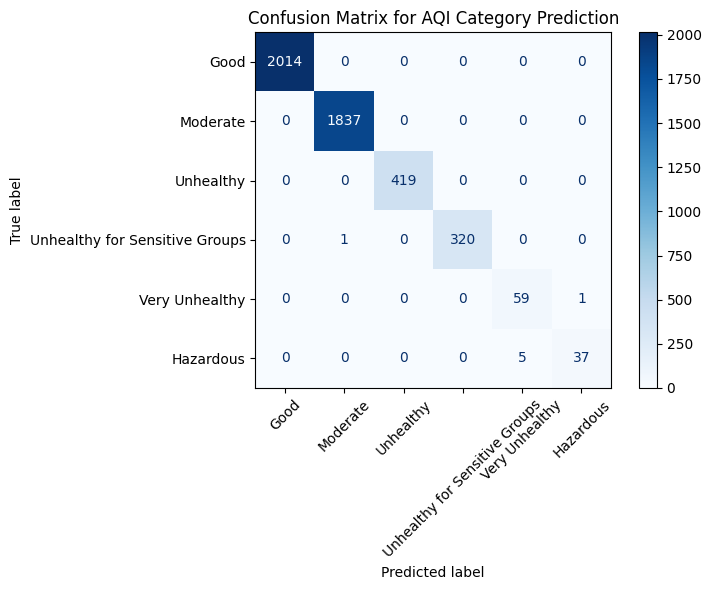

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test_decoded, y_predict_decoded, labels=category_value)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_value)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix for AQI Category Prediction")
plt.grid(False)
plt.tight_layout()
plt.show()


C:\Users\Student\AppData\Local\Temp\ipykernel_2884\2208720978.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pred_df, x='Actual', order=category_value, palette='viridis', alpha=0.7, label='Actual')
C:\Users\Student\AppData\Local\Temp\ipykernel_2884\2208720978.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pred_df, x='Predicted', order=category_value, palette='cool', alpha=0.4, label='Predicted')


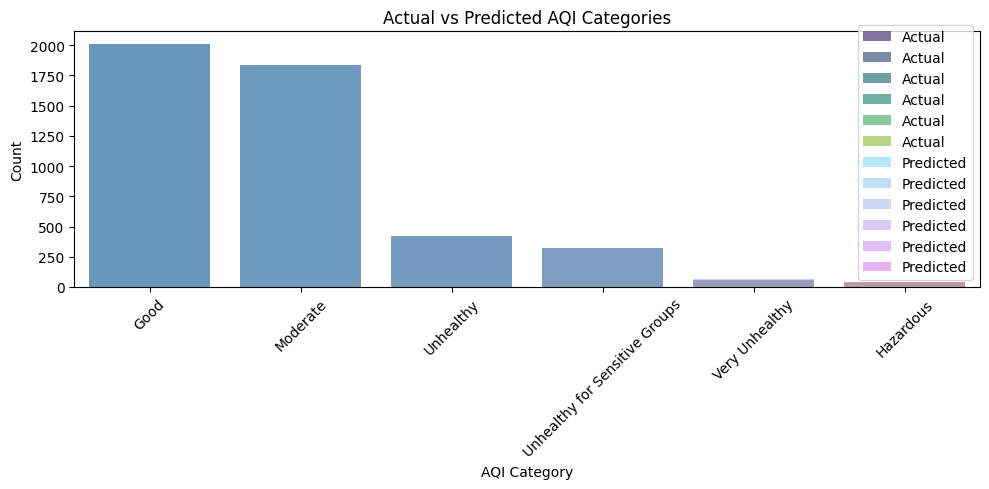

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame for actual vs predicted
pred_df = pd.DataFrame({'Actual': y_test_decoded, 'Predicted': y_predict_decoded})

# Plot overlayed count distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=pred_df, x='Actual', order=category_value, palette='viridis', alpha=0.7, label='Actual')
sns.countplot(data=pred_df, x='Predicted', order=category_value, palette='cool', alpha=0.4, label='Predicted')
plt.title('Actual vs Predicted AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset with outliers
df = pd.read_csv("global_air_pollution_with_outliers.csv")
df.head()


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0.000000,Good,51.0,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1.000000,Good,41.0,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,57.332738,Good,66.0,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0.000000,Good,20.0,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0.000000,Good,6.0,Good


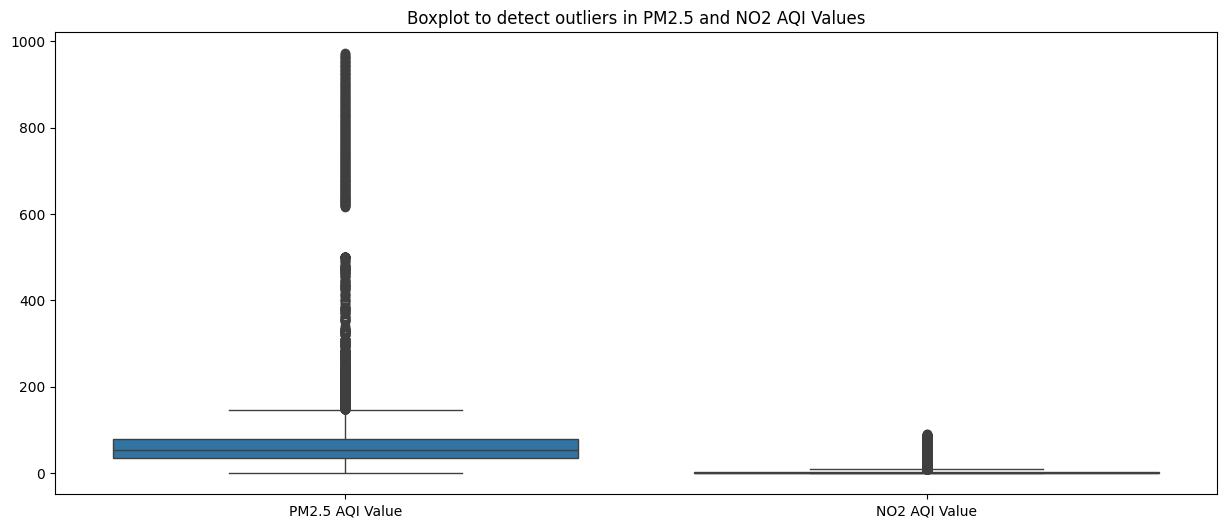

In [16]:

plt.figure(figsize=(15, 6))
sns.boxplot(data=df[['PM2.5 AQI Value', 'NO2 AQI Value']])
plt.title("Boxplot to detect outliers in PM2.5 and NO2 AQI Values")
plt.show()


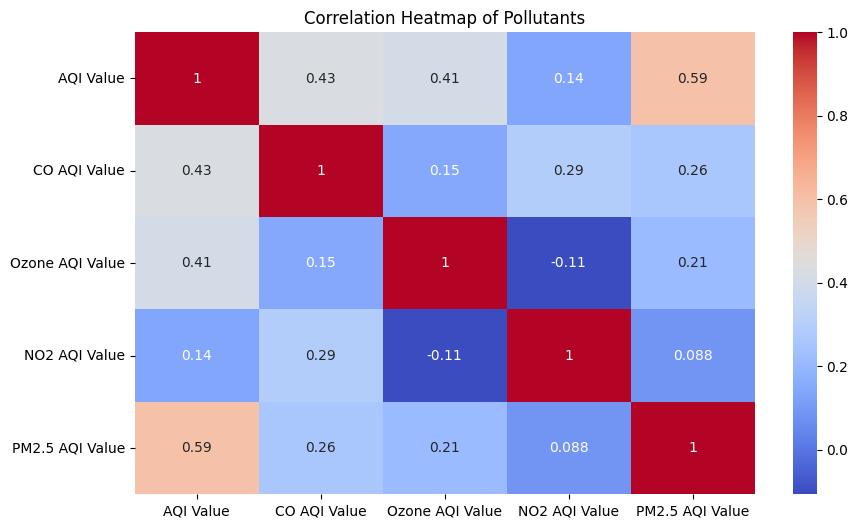

In [17]:

plt.figure(figsize=(10, 6))
sns.heatmap(df[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Pollutants")
plt.show()


In [18]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = df[['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']]
y = LabelEncoder().fit_transform(df['AQI Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2014
           1       0.95      0.88      0.91        42
           2       0.99      0.99      0.99      1837
           3       0.96      0.99      0.97       419
           4       0.99      0.95      0.97       321
           5       0.88      0.83      0.85        60

    accuracy                           0.98      4693
   macro avg       0.96      0.94      0.95      4693
weighted avg       0.98      0.98      0.98      4693

Accuracy: 0.9842318346473471


Linear Regression R^2 Score: 0.4821647472854983
MSE: 1650.156094828335


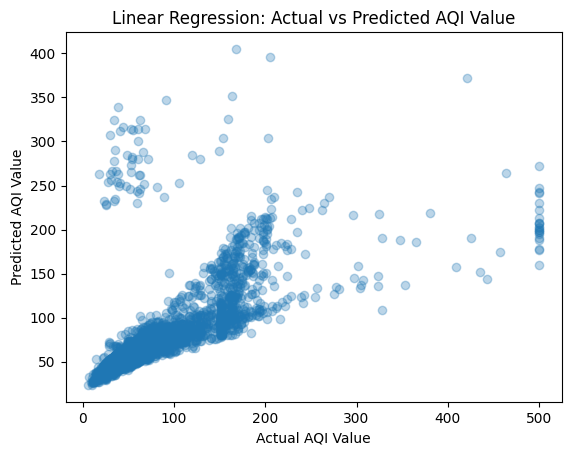

In [19]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Target: AQI Value
y_reg = df['AQI Value']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
y_pred_reg = lr.predict(X_test_reg)

print("Linear Regression R^2 Score:", r2_score(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))

# Plotting
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.xlabel("Actual AQI Value")
plt.ylabel("Predicted AQI Value")
plt.title("Linear Regression: Actual vs Predicted AQI Value")
plt.show()
